In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import os 
from scipy.ndimage import rotate
from numpy.fft import fftshift
import scipy.interpolate
# local files

#import CTfilter as CTfilter

1) Sur le site de XCOM, nous pouvons visualiser l'atténuation dans l'eau d'un rayon de 60 keV. En considérant un faisceau cohérent, l'atténuation pour un rayon de 60 kev avec de la diffusion cohérente est de 0.2059 cm $^2$/g. En multipliant par la masse volumique de l'eau de 1 g/cm $^3$ , nous obtenons une valeur de 0.2059 cm $^{-1}$. \
Après 5 cm:

$$\ln(\frac{I_0}{I}) = 0.2059\; cm^{-1}\cdot 5\; cm$$
$$\frac{I}{I_0} = \frac{1}{e^{1.0295}}= 0.36 $$

Après 20 cm:
$$\ln(\frac{I_0}{I}) = 0.2059\; cm^{-1}\cdot 20\; cm$$
$$\frac{I}{I_0} = \frac{1}{e^{4.11}}= 0.0163 $$

2) 

In [3]:
## VARIABLES ###

### paramètres d'acquisition ###

## largeur d'un élément de détecteur (cm)
pixsize = 0.165

## taille du détecteur (nombre d'échantillons)
nbpixg = 336

### paramètres de reconstruction ###

## taille de la grille d'image (carrée)
nbvox = 192 # options: 96, 192

## taille du voxel (carré) (cm)
voxsize = 0.2 # option: 0.4, 0.2

## fichiers d'entrée
dataDir = "./TP4/"
anglesFile = "angles.txt"
#sinogramFile = "sinogram-password.txt"
sinogramFile = "sinogram-patient.txt"


In [4]:
def readAngles(filename):

    angles = np.loadtxt(filename)
    nbprj = angles.shape[0]

    # convertir en radians element par element
    angles = (np.pi/180.0)*angles

    return [nbprj, angles]


## lire un sinogramme
def readSinogram(filename):
    
    sinogram = np.loadtxt(filename)
    nbprj = sinogram.shape[0]
    nbpix = sinogram.shape[1]

    return [nbprj, nbpix, sinogram]


#enregistrer l'image
def saveImage(image, prefix):
    im = plt.imshow(image, cmap = cm.Greys_r)
    plt.colorbar()
    plt.title("method: "+prefix)
    plt.savefig(prefix+"-"+time.strftime("%Y%m%d-%H%M%S")+".png")


In [ ]:
def readInput():
    # lire les angles
    angle_path= os.path.abspath("angles.txt")
    sino_path= os.path.abspath("sinogram-patient.txt")
    [nbprj, angles] = readAngles(angle_path)

    # lire le sinogramme
    [nbprj2, nbpix2, sinogram] = readSinogram(sino_path)
    return [nbprj, angles, sinogram]


## reconstruire une image TDM en mode rétroprojection
def laminogram():
    
    [nbprj, angles, sinogram] = readInput()


    # initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    center_x = nbvox / 2
    center_y = nbvox / 2
    for j in range(nbvox): # colonnes de l'image
        print("working on image column: "+str(j+1)+"/"+str(nbvox))
        for i in range(nbvox): # lignes de l'image

            x = (j - center_x) * voxsize
            y = (center_y - i) * voxsize
            posi = np.array([[x],
                            [y]])

            for a in range(len(angles)):
                theta = angles[a]
                # On utilise la matrice de rotation afin d'exprimer
                # les coordonnées du voxel dans le système du détecteur
                R = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]]) 
                posi_prime = np.matmul(R, posi)


                # Valeur du sinogramme associée à la position du voxel
                val_xsino = round(float(posi_prime[0]/pixsize))
   
                image [i, j] += sinogram[a, round(nbpixg/2 + val_xsino)]
             
    saveImage(image, "lam")

laminogram()

2) L'image reconstitué à beaucoup moins de détail que l'image fantôme. Sur l'image phantome on distingue bien les os et les contours, dans l'image reconstitué, beaucoup de bruit bloque complétement tous les détails.

In [ ]:
#3 
## filtrer le sinogramme
## ligne par ligne
import numpy as np

def filterSinogram(sinogram):
    filtered_sinogram = np.zeros_like(sinogram)  # Create an array to store filtered sinogram
    for i in range(sinogram.shape[0]):
        filtered_sinogram[i] = filterLine(sinogram[i])
    return filtered_sinogram

def filterLine(projection):
    dft = np.fft.fft(projection)
    frequence_shift = np.fft.fftshift(dft)

    filter_len = len(projection)

    filtre_rampe = np.abs(np.arange(-frequence_shift.shape[0]/2,frequence_shift.shape[0]/2, 1))

    filtre_freq = frequence_shift * filtre_rampe


    filtre_freq = np.fft.ifftshift(filtre_freq)
    filtered_projection = np.fft.ifft(filtre_freq)

    filtered_projection = np.real(filtered_projection)

    return filtered_projection


[nbprj, angles, sinogram] = readInput()
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogramme sans filtre')
plt.xlabel('Angle')
plt.ylabel('Position')
plt.colorbar(label='Intensité')
plt.show()


sinogram = filterSinogram(sinogram)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogramme filtré')
plt.xlabel('Angle')
plt.ylabel('Position')
plt.colorbar(label='Intensité')
plt.show()


3) C'est un peu comme si on avait beaucoup diminiué le contraste, mais en fait c'est parce que l'image filtré à beacoup plus de contraste entre son intensité la plus élevé et la moins élevé. Mais, les structures à l'intérieur du sinogramme sont vraiment plus facile à voir et discerner les uns des autres.

In [ ]:
#Q4
def laminogram():
    
    [nbprj, angles, sinogram] = readInput()
    sinogram = filterSinogram(sinogram)

    # initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    center_x = nbvox / 2
    center_y = nbvox / 2
    for j in range(nbvox): # colonnes de l'image
        print("working on image column: "+str(j+1)+"/"+str(nbvox))
        for i in range(nbvox): # lignes de l'image

            x = (j - center_x) * voxsize
            y = (center_y - i) * voxsize
            posi = np.array([[x],
                            [y]])

            for a in range(len(angles)):
                theta = angles[a]

                R = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
                posi_prime = np.matmul(R, posi)



                val_xsino = round(float(posi_prime[0]/pixsize))
   
                image [i, j] += sinogram[a, round(nbpixg/2 + val_xsino)]
                  
    saveImage(image, "lamfiltré")

laminogram()

4) La première chose que je remarque maintenant avec plus de détail, c'est que notre image est inversé par rapport à l'image fantôme. Mais, je dirai qu'en général, notre image semble avoir une meilleur résolution que celle phantôme, les os sont plus détaillé. Par contre, la partie plus sombre au centre semble plus pâle dans notre image que celle phantôme, et c'est probablement dû aux basses fréquences enlevées par le filtre.

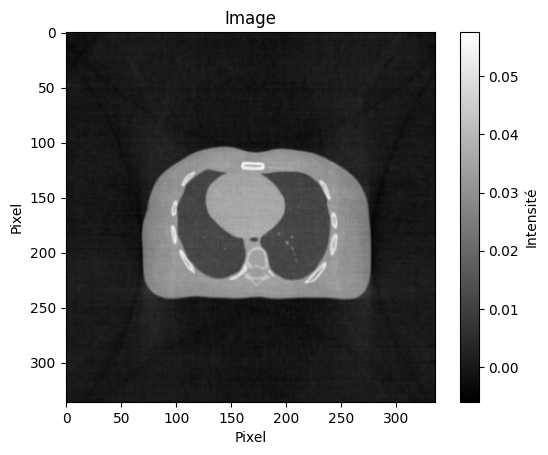

In [5]:
#Q5

def reconFourierSlice():
    
    angle_path= os.path.abspath("angles.txt")
    [nbprj, angles] = readAngles(angle_path)
    sino_path= os.path.abspath("sinogram-patient.txt")
    [nbprj2, nbpix2, sinogram] = readSinogram(sino_path) 

    #initialise une image reconstruite
    image = np.zeros((nbpix2,nbpix2),'complex')

    #fft sur le sinogram
    sinogram_fft_rows = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=1)), axes=1)

    #géométrie du sinogram
    a = angles
    r = np.arange(nbpix2) - nbpix2 / 2
    r, a = np.meshgrid(r, a)
    r = r.flatten()
    a = a.flatten()
    srcx = (nbpix2 / 2) + r * np.cos(a)
    srcy = (nbpix2 / 2) + r * np.sin(a)

    #géométrie qu'on veut pour l'image
    dstx, dsty = np.meshgrid(np.arange(nbpix2), np.arange(nbpix2))
    dstx = dstx.flatten()
    dsty = dsty.flatten()

    #interpolation
    fft2 = scipy.interpolate.griddata((srcy, srcx),sinogram_fft_rows.flatten(),(dsty, dstx),method="linear",fill_value=0.0,).reshape((nbpix2, nbpix2))

    #fft inverse en 2d
    image = (np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft2))))

    #on garde seulement les nombres réels
    return np.real(image)



sinogram = reconFourierSlice()
plt.imshow(sinogram, cmap='gray')
plt.title('Image')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar(label='Intensité')
plt.show()

5) Définitivement la meilleur image jusqu'à date, les détails des os sont vraiment beaucoup meilleurs que sur les images précédentes et l'image phantôme. Elle reste inversé par contre. Et on peut vaguement distingué 2 lignes blanches courbes passant par les côté de l'adbomen. De plus, le temps de calcul est meilleur que les deux autres méthodes de plus d'un facteur 10. 